# Lets do some data exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rdm

In [2]:

types_train = {'Sales': np.int32,
               'Store': np.int32,
               'DayOfWeek': np.int32,
               'Date': str,
               'Customers': np.int32,
               'Open': bool,
               'Promo': bool,
               'StateHoliday': str,
               'SchoolHoliday': bool}

df_train = pd.read_csv('./data/train.csv', dtype=types_train, parse_dates=['Date'])
df_train.dtypes

Store                     int32
DayOfWeek                 int32
Date             datetime64[ns]
Sales                     int32
Customers                 int32
Open                       bool
Promo                      bool
StateHoliday             object
SchoolHoliday              bool
dtype: object

Okay, we read the data correctly. Now lets get a feeling for the variables

In [3]:
df_train['Sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

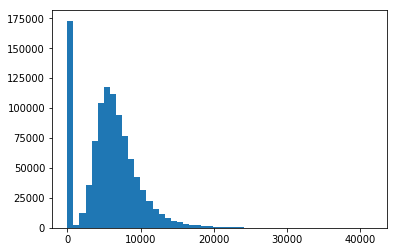

In [4]:
plt.hist(x=df_train['Sales'], bins=50);

Mean and deviation are affected by the days with 0 sales, but these are probably going to be predicted easily using the "Open" feature

In [5]:
df_clean_sales = df_train[df_train['Sales'] > 0]
df_clean_sales['Sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

In [6]:
entries_per_store = df_train.groupby('Store').size()
print(entries_per_store.to_frame(name='Entries per store').describe())

       Entries per store
count        1115.000000
mean          912.295067
std            67.729422
min           758.000000
25%           942.000000
50%           942.000000
75%           942.000000
max           942.000000


There are indeed 1115 different stores, as descripted in the kaggle challenge. Normally there are 942 datapoints (=days) per store, some have a bit less but at least 758.

Lets do some sanity checks. This helps to see if we understand the data correctly or find errors in the data (unlikly for a kaggle challenge though)

In [7]:
print("Missing values? " + str(df_train.isnull().values.any()))
print('Percentage of days with 0 sales: {0:0.2f}'.format((df_train['Sales'] == 0).sum() / len(df_train['Sales'])))

Missing values? False
Percentage of days with 0 sales: 0.17


Seems reasonable, as 14% of the days are Sundays

In [8]:
print("Entries with 0 sales: " + 
      str((df_train['Sales'] == 0).sum()))
print("Entries with 0 sales and shop is closed: " + 
      str(len(df_train[(df_train['Sales'] == 0) & (~(df_train['Open']))])))
print("Entries with 0 sales although shop is open: " + 
      str(len(df_train[(df_train['Sales'] == 0) & (df_train['Open'])])))
print("Entries with sales > 0 although shop is closed: " + 
      str(len(df_train[(df_train['Sales'] > 0) & (~df_train['Open'])])))

Entries with 0 sales: 172871
Entries with 0 sales and shop is closed: 172817
Entries with 0 sales although shop is open: 54
Entries with sales > 0 although shop is closed: 0


No sales for an open shop seems odd, but 54 out of over 172817 isn't that much. Even if these points are errornous, they wont have a big impact.

In [9]:
print("Entries with store is open on a state holiday: " + 
      str(len(df_train[(df_train['StateHoliday'] != '0') & (df_train['Open'])])))
print("Entries with store is closed on a state holiday: " + 
      str(len(df_train[(df_train['StateHoliday'] != '0') & (~(df_train['Open']))])))

Entries with store is open on a state holiday: 910
Entries with store is closed on a state holiday: 30140


Now lets get a feeling for the other variables, and how big their impact on the sales are. Lets have a look at the correlation matrix

In [10]:
df_train['StateHoliday'] = pd.Categorical(df_train['StateHoliday']).codes
corr = df_train.corr(method='pearson')
corr.round(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,1.00,-0.00,0.01,0.02,-0.00,0.00,0.00,0.00
DayOfWeek,-0.00,1.00,-0.46,-0.39,-0.53,-0.39,-0.04,-0.21
Sales,0.01,-0.46,1.00,0.89,0.68,0.45,-0.23,0.09
Customers,0.02,-0.39,0.89,1.00,0.62,0.32,-0.20,0.07
Open,-0.00,-0.53,0.68,0.62,1.00,0.30,-0.34,0.09
Promo,0.00,-0.39,0.45,0.32,0.30,1.00,-0.02,0.07
StateHoliday,0.00,-0.04,-0.23,-0.20,-0.34,-0.02,1.00,0.20
SchoolHoliday,0.00,-0.21,0.09,0.07,0.09,0.07,0.20,1.00


count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64


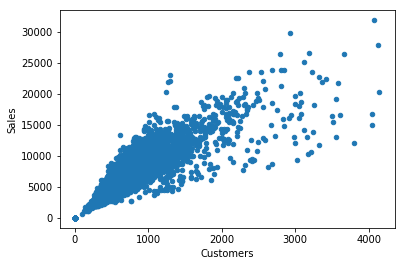

In [11]:
print(df_train['Customers'].describe())
subs_idx = rdm.sample(range(len(df_train)), 8000)
df_subset = pd.concat([df_train['Sales'], df_train['Customers']], axis=1).iloc[subs_idx]
df_subset.plot.scatter(x='Customers', y='Sales')

As expected, we can see a linear relationship between the amount of customers and the sales of a shop. With a correlation of nearly 90% to the target variable, this feature will help a lot to predict the sales.

In [12]:
df_daygrouped = df_train.groupby(['DayOfWeek']).sum()[['Sales', 'Open']]
df_daygrouped['Average Sale per Day'] = df_daygrouped['Sales']/df_daygrouped['Open']
df_daygrouped.round(2)

,Sales,Open,Average Sale per Day
DayOfWeek,,,
1,1130203012,137560.0,8216.07
2,1020411930,143961.0,7088.11
3,954962863,141936.0,6728.12
4,911177709,134644.0,6767.31
5,980555941,138640.0,7072.68
6,846317735,144058.0,5874.84
7,29551433,3593.0,8224.72


Opening on Sundays seems to pay off. No big difference between Tue, We, Thu, Fr

Let's train a really simple linear regression model, using only the (seemingly) most important feature, the amount of customers. This helps to get a feeling for the difficulty of predicting the sales and gives a baseline to compare other approaches with.


In [16]:
from sklearn import linear_model


#Cast to numpy for scikit-learn and only take the non-trivial datapoints
ar_data = df_train[df_train['Open'] == True].as_matrix(columns=['Sales', 'Customers'])

# Take 20% of randomly chosen datapoints for evaluation
n = len(ar_data)
np.random.shuffle(ar_data)
amnt_eval = int(np.round(0.2*n))
train_set = ar_data[amnt_eval:]
eval_set = ar_data[:amnt_eval]

# Train the model
linregr = linear_model.LinearRegression()
linregr.fit(X=train_set[:, 1].reshape(-1, 1), y=train_set[:, 0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Lets use the same evaluation function as in the original challenge: "Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE) [..] Any day and store with 0 sales is ignored in scoring."

In [17]:
eval_y_pred = linregr.predict(eval_set[:, 1].reshape(-1, 1))
def rmspe(ar_pred, ar_truth):
    """
    Calculates the root mean square percentage error. Any entries with a truth value of 0 are ignored
    """
    nonzero_idx = np.nonzero(ar_truth)
    ar_pred = ar_pred[nonzero_idx]
    ar_truth = ar_truth[nonzero_idx]
    spe = np.power(np.divide(np.subtract(ar_pred, ar_truth), ar_truth), 2)
    return np.sqrt(spe.mean())


print("RMSPE: {0:0.3f}".format(rmspe(eval_y_pred, eval_set[:, 0])))

RMSPE: 0.282


Not too bad regarding the fact we only used a single feature. Now lets find out if we could use some usefull information from the date, a feature we havent really looked at yet.

In [18]:
df_train['Date'].describe()

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

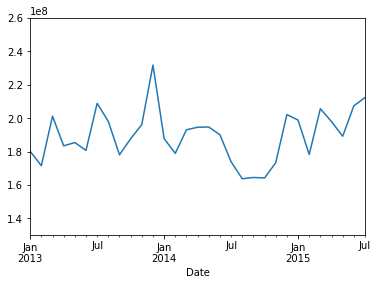

In [19]:
df_dateidx = df_train[['Sales', 'Date']].set_index('Date')
df_dateidx = df_dateidx.resample('M').sum()
#print(df_dateidx)
ax = df_dateidx['Sales'].plot()
ax.set_ylim([1.3 * 10**8, 2.6 * 10**8])
plt.show()

It is unlikely that we can craft a useful feature from the date. There isnt really a correlation between month and sales, e.g. Jul 2014 is the all-time low but Jul '13 and '15 have quite high sales. 

Good thing we have some more features regarding the stores, lets check out what we got there

In [20]:
types_store = {'Store': np.int32,
               'StoreType': str,
               'Assortment': str,
               'CompetitionDistance': str, # cant use int here, some cells are empty
               'CompetitionOpenSinceMonth': str,
               'CompetitionOpenSinceYear': str,
               'Promo2': bool,
               'Promo2SinceWeek': str,
               'Promo2SinceYear': str,
               'PromoInterval': str}
df_store = pd.read_csv('./data/store.csv',
                       dtype=types_store)
print('Amount of rows: ' + str(len(df_store)))    
print('Missing values? ' + str(df_store.isnull().values.any()))
df_store.dtypes

Amount of rows: 1115
Missing values? True


Store                         int32
StoreType                    object
Assortment                   object
CompetitionDistance          object
CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
Promo2                         bool
Promo2SinceWeek              object
Promo2SinceYear              object
PromoInterval                object
dtype: object

In [21]:
df_store.replace('', np.nan, inplace=True)
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We need to do some data cleansing. Lets replace missing values at 'CompetitionDistance' with the median of that column. (Median is more robust to outliers than the mean) 

In [22]:
comp_dist_avg = df_store[~df_store['CompetitionDistance'].isnull()]['CompetitionDistance'].astype(np.float32).median()
print('Median distance to competitors: ' + str(comp_dist_avg))
comp_dist_avg = int(np.round(comp_dist_avg))
#df_store[df_store['CompetitionDistance'].isnull()]['CompetitionDistance'] = str(comp_dist_avg)
df_store['CompetitionDistance'].replace(np.nan, str(comp_dist_avg), inplace=True)
df_store['CompetitionDistance'] = df_store['CompetitionDistance'].astype(np.int32)
df_store.dtypes

Median distance to competitors: 2325.0


Store                         int32
StoreType                    object
Assortment                   object
CompetitionDistance           int32
CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
Promo2                         bool
Promo2SinceWeek              object
Promo2SinceYear              object
PromoInterval                object
dtype: object

Finding meanfull replacements for the columns "CompetitionOpenSinceMonth/Year' is more difficult. Lets have a closer look at these variables and if they actually influence the sales.

In [23]:
len(df_store[df_store['CompetitionOpenSinceYear'].isnull() & df_store['CompetitionOpenSinceYear'].isnull()])

354

We already knew that there are 354 null values in each column. So we either have both of them, or neither

In [24]:
df_comps = df_store[~df_store['CompetitionOpenSinceYear'].isnull()][['Store', 'CompetitionOpenSinceYear']]
df_comps = df_comps.astype(np.int32)
df_comps.describe()

,Store,CompetitionOpenSinceYear
count,761.000000,761.000000
mean,556.797635,2008.668857
std,322.605611,6.195983
min,1.000000,1900.000000
25%,281.000000,2006.000000
50%,570.000000,2010.000000
75%,831.000000,2013.000000
max,1112.000000,2015.000000


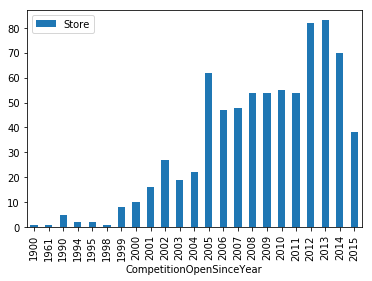

In [25]:
df_comps.groupby(['CompetitionOpenSinceYear']).count().plot.bar()

1900 is an outlier. It probably also doesnt make a difference if a competitor opened 20 or 30 years ago, so we can think about simplifying the data by unifying all pre-2000 datapoints. But lets see the relationship with the sales first.

In [26]:
df_comps = df_store[~df_store['CompetitionOpenSinceYear'].isnull()]
df_comps = df_comps.astype(dtype={'CompetitionOpenSinceYear': np.int32,
                       'CompetitionOpenSinceMonth': np.int32})
df_merge = pd.merge(df_train[['Store','Sales']], df_comps, how = 'inner', on = 'Store')
df_merge = df_merge.groupby('Store').agg(np.mean)
df_merge.corr(method='pearson')

,Sales,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
Sales,1.000000,-0.048979,-0.052453,0.018893,-0.176585
CompetitionDistance,-0.048979,1.000000,-0.059126,0.025124,-0.140708
CompetitionOpenSinceMonth,-0.052453,-0.059126,1.000000,-0.052250,-0.011485
CompetitionOpenSinceYear,0.018893,0.025124,-0.052250,1.000000,-0.076520
Promo2,-0.176585,-0.140708,-0.011485,-0.076520,1.000000


We aggregated over different dates using the mean, so sales contains the average sale per day for a certain store. The other values are simply the corresponding values for each store. We dont really see any high correlation values here. Suprisingly, Promo2 seems to have a negativ effect on the sales.

Lets just replace the missing values with 0 for now, one-hot encode the categorical features and get our complete dataset.

In [27]:
df_store.replace(np.nan, 0, inplace=True)
df_store.drop('PromoInterval', axis = 1)
df_store = df_store.astype(dtype={'CompetitionOpenSinceYear': np.int32,
                       'CompetitionOpenSinceMonth': np.int32})
df_merge = pd.merge(df_train, df_comps, how = 'inner', on = 'Store')
df_merge['Assortment'] = pd.Categorical(df_merge['Assortment']).codes
df_merge['StoreType'] = pd.Categorical(df_merge['StoreType']).codes
df_merge = df_merge.drop(labels=['Date'], axis=1)
df_merge=df_merge.fillna(value=0)
df_merge.describe()

,Store,DayOfWeek,Sales,Customers,StateHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
count,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000
mean,556.501521,3.998350,5780.898006,633.288927,0.044915,1.146443,0.852266,5414.271057,7.222866,2008.690228
std,322.512188,1.997392,3874.982491,455.927727,0.283231,1.347344,0.986967,7832.744154,3.211832,5.992644
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.000000,1900.000000
25%,281.000000,2.000000,3680.000000,401.000000,0.000000,0.000000,0.000000,720.000000,4.000000,2006.000000
50%,569.000000,4.000000,5743.000000,613.000000,0.000000,0.000000,0.000000,2230.000000,8.000000,2010.000000
75%,833.000000,6.000000,7890.000000,845.000000,0.000000,3.000000,2.000000,6470.000000,10.000000,2013.000000
max,1112.000000,7.000000,38722.000000,7388.000000,3.000000,3.000000,2.000000,58260.000000,12.000000,2015.000000


# Model training and evaluation

Lets see how well linear regression performs using all features:

In [28]:
df_merge = df_merge[df_merge['Open'] == True]
# Reorder so that the target variable is at first position
cols = list(df_merge.columns.values)
cols.remove('Sales')
cols.remove('Store')
cols.remove('Open')
cols.remove('PromoInterval')
cols = ['Sales'] + cols
df_merge_sub = df_merge[cols]
#Cast to numpy for scikit-learn
ar_data = df_merge_sub.as_matrix()
# Take 20% of randomly chosen datapoints for evaluation
n = len(ar_data)
np.random.shuffle(ar_data)
amnt_eval = int(np.round(0.2*n))
train_set = ar_data[amnt_eval:]
eval_set = ar_data[:amnt_eval]
# Train the model
linregr = linear_model.LinearRegression()
linregr.fit(X=train_set[:, 1:], y=train_set[:, 0])
# Make predictions using the testing set
eval_y_pred = linregr.predict(eval_set[:, 1:])
print("RMSPE: %.3f" % rmspe(eval_y_pred, eval_set[:, 0]))

RMSPE: 0.203


We get an 8% improvement compared to only using the amount of customers.Now lets try a model that typically is a bit more flexible and might fit better than a pure linear model: Support Vector Regression. Using non-linear kernels they can adjust to data that linear regression cant. However, they dont scale very well and our dataset is too big for a single SVR. So we split the dataset and train an ensemble.
-- ATTENTION: Evaluating the next cell will take a lot of time and is not necessary for the rest of the cells 

In [61]:
from sklearn import decomposition
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
#Cast to numpy for scikit-learn
ar_data = df_merge_sub.as_matrix()
n = len(ar_data)
print('Available datapoints: ' + str(n))
# Split target variable from rest, apply PCA
np.random.shuffle(ar_data)
X=ar_data[:, 1:] 
y=ar_data[:, 0]
pca = decomposition.PCA(n_components=5)
pca.fit(X)
X = pca.transform(X)
# Take 20% of randomly chosen datapoints for evaluation
amnt_eval = int(np.round(0.2*n))
X_train = X[amnt_eval:]
X_eval = X[:amnt_eval]
y_train = y[amnt_eval:]
y_eval = y[:amnt_eval]
# Train the model
svr_ensemble = BaggingRegressor(base_estimator=SVR(kernel='linear', C=100, degree=2, epsilon=10, tol=1),
                                n_estimators=3,
                                max_samples=5000,
                                max_features=5,
                                bootstrap=False,
                                n_jobs=-1,
                                verbose=100)
                                
svr_ensemble.fit(X=X_train, y=y_train)
# Make predictions using the testing set
eval_y_pred = svr_ensemble.predict(X_eval)

print(eval_y_pred[0:10])
print(y_eval[0:10])
print(y[0:10])

print("RMSPE: %.3f" % rmspe(eval_y_pred, y_eval))

/home/adrian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


575041
Pickling array (shape=(3,), dtype=int64).
Memmaping (shape=(460033, 5), dtype=float64) to new file /dev/shm/joblib_memmaping_pool_13923_140296497530360/13923-140297047146392-2ceca5255f425624626dacaf841d8384.pkl
Pickling array (shape=(460033,), dtype=object).
Pickling array (shape=(1,), dtype=int64).
Pickling array (shape=(3,), dtype=int64).
Memmaping (shape=(460033, 5), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_13923_140296497530360/13923-140297047146392-2ceca5255f425624626dacaf841d8384.pkl
Pickling array (shape=(460033,), dtype=object).
Building estimator 1 of 1 for this parallel run (total 3)...
Building estimator 1 of 1 for this parallel run (total 3)...
Pickling array (shape=(1,), dtype=int64).
Pickling array (shape=(3,), dtype=int64).
Memmaping (shape=(460033, 5), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_13923_140296497530360/13923-140297047146392-2ceca5255f425624626dacaf841d8384.pkl
Pickling array (shape=(460033,), dtype=object).
Pickling a

Even the ensemble takes quite a lot of time: Training 3 SVMs in parallel with only 5000 out of 575041 takes 160min on a feature space reduced to 5 features using PCA. Due to time constraints I therefore didnt actually compute the ensemble I had in mind (10 SVMs with polynomial kernel on 10000 points). Regarding the fact that a very tiny subset of the available data was used and no hyper-parameter tuning (C and epsilon) was done yet, the resulting 0.359 RMSPE do not look that bad.

If we want to a get a esemble that does not take that long, Random Forests are the way to go. Random forests show competing results on a range of problems, so lets see what we get.

In [29]:
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor
X=ar_data[:, 1:] 
y=ar_data[:, 0]
# Take 20% of randomly chosen datapoints for evaluation
amnt_eval = int(np.round(0.2*n))
X_train = X[amnt_eval:]
X_eval = X[:amnt_eval]
y_train = y[amnt_eval:]
y_eval = y[:amnt_eval]
# Train the model
forest = RandomForestRegressor(n_estimators=27, n_jobs=-1)
                                
forest.fit(X=X_train, y=y_train)
# Make predictions using the testing set
eval_y_pred = forest.predict(X_eval)

print("RMSPE: %.3f" % rmspe(eval_y_pred, y_eval))

RMSPE: 0.073


As we can see the random forest fit the data pretty well and achieve an impressive RMSPE of ~7% on the evaluation set. Future work to further improve this model could include crafting additional features or removing outliers.